# Online convex programming example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Description of the testbed problem

Consider the following problem in two dimensions:

Feasible set $X$ is the unit circle

The sequence of convex functions is given as
$$
    c^t(x,y) = (x-x_1^{(t)})^2 + (y-y_1^{(t)})^2
$$

where we generate $x_1^{(t)}$ and $y_1^{(t)}$ from multivariate Gaussian density $\mathcal{N}(0,I)$.

The gradient is
$$
    \nabla c^t(x,y) = 
    \begin{pmatrix}
        2(x-x_1^{(t)}) \\
        2(y-y_1^{(t)})
    \end{pmatrix}
$$

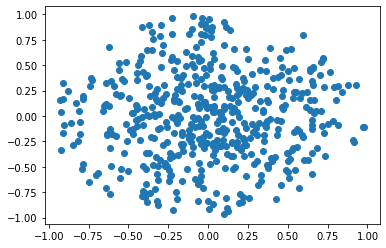

In [69]:
# generate the given series of functions
seq_length = 500
dim = 2
samples = []
while len(samples) <= seq_length:
    sample = np.random.normal(scale=0.5,size=dim)
    if np.linalg.norm(sample) <= 1:
        samples.append(sample)
samples = np.array(samples)
plt.scatter(samples[:,0], samples[:,1])

In [63]:
from scipy.optimize import minimize

In [70]:
def grad(x, center):
    return 2*(x-center)
def cost(x,center):
    return (x-center)@(x-center)
# come up with a sequence of guesses via greedy projection
x0 = np.array([0,0])
x_t = [x0]
costs = []
for t,sample in enumerate(samples):
    # get the gradient of the given function
    this_step = 1/np.sqrt(t+1)
    last_x = x_t[-1]
    costs.append(cost(last_x,sample))
    this_grad = grad(last_x,sample)
    unproj_step = last_x - this_step*this_grad
    # do the projection
    result = minimize(
        fun = lambda x: (x-unproj_step) @ (x-unproj_step),
        x0 = np.array([0,0]),
        jac = lambda x: (x-unproj_step),
        constraints = ({
            'type':'ineq',
            'fun': lambda x: -x@x +1
        })
    )
    if result.status == 0:
        x_t.append(result.x)
    else:
        x_t.append(last_x)

In [71]:
# in comparison, try to find the best fixed vector
offline_result = minimize(
    fun = lambda x: sum([cost(x,center) for center in samples]),
    x0 = np.array([0,0]),
    jac = lambda x: sum([grad(x,center) for center in samples]),
    constraints = ({
            'type':'ineq',
            'fun': lambda x: -x@x +1
        }),
    method='SLSQP'
)
print(offline_result)
offline_x = offline_result.x

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 176.41081233096716
       x: [ 7.727e-04  1.259e-03]
     nit: 2
     jac: [ 1.545e-03  2.519e-03]
    nfev: 5
    njev: 2


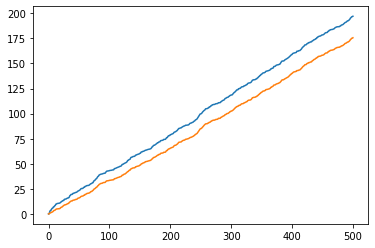

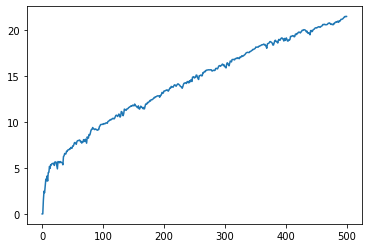

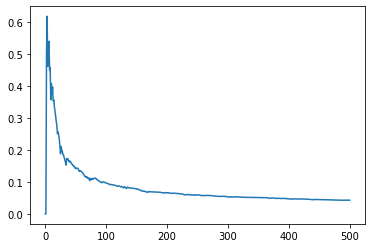

In [83]:
rolling_costs = [sum(costs[j] for j in range(i)) for i in range(len(costs))]
offline_costs = [cost(offline_x,center) for center in samples]
rolling_offline_costs = [sum(offline_costs[j] for j in range(i)) for i in range(len(offline_costs))]

plt.plot(rolling_costs)
plt.plot(rolling_offline_costs)
plt.figure()
plt.plot(np.array(rolling_costs)-np.array(rolling_offline_costs))
plt.figure()
plt.plot((np.array(rolling_costs)-np.array(rolling_offline_costs))/np.arange(1,seq_length+2))